In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from mesa.space import MultiGrid
import pandas as pd
import numpy as np


import random
import numpy as np
import sys
import matplotlib.pyplot as plt

#### Модели на основе которой я это делал (распространение новостей и подсчёт индекса Джини)

https://datasciencechalktalk.com/2020/06/07/understanding-agent-based-model-with-python/

https://mesa.readthedocs.io/en/stable/tutorials/intro_tutorial.html

In [118]:
def compute_wishdem(model):
        return  sum([1 for a in model.schedule.agents if a.wishdem == 1])

class MyModel(Model):
    def __init__(self, N, width, height, economic_growth, repression_start): 
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.economic_growth=economic_growth
        self.repression_start=repression_start
        self.running = True 
        self.t = 0
        self.steps = 100 #количество шагов в модели
        self.shocks=10 #когда наступает шок
        
        for i in range(self.num_agents):
            a = MoneyAgent(i, self, economic_growth, repression_start)
            self.schedule.add(a)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
            
        self.datacollector = DataCollector(
            model_reporters = {"Tot informed": compute_wishdem},
            agent_reporters={"Wishdem": "wishdem"})

    def run(self):
        """
        Запускает модель: пока модель активна делает шаг такта,
        обновляет текущий такт и статус модели
        """
        while self.running == True:
            self.step()
            self.t += 1
            self.check_running()
            self.shock()
        
    def step(self):
        self.schedule.step() 
        self.datacollector.collect(self)
        
    def check_running(self):
        """
        Если число агентов, которы хотя демократию привысило определённый порог
        Случается демократический транзит и модель заканчивается
        """
        
        if (self.t > self.steps) | (sum([1 for a in model.schedule.agents if a.wishdem == 1]) > 500): #не склеивается
            self.running = False
        
    def shock(self): 
        if self.t == self.shocks:
            for agent in self.schedule.agents: 
                if agent.wishdem==0:
                    if random.random()<0.5:
                        agent.wishdem=1
 

class MoneyAgent(Agent):
    """ 
    У агента фиксированное число богатства (от 0 до 1)
    Агенты сначала НЕ хотят демократии
    """
    def __init__(self, unique_id, model, economic_growth, repression_start):
        super().__init__(unique_id, model)
        self.wealth = random.random() #ИЗНАЧАЛЬНО БОГАТСТВО ЗАДАЁТСЯ СЛУЧАЙНО (как это и есть в мире)
        self.wishdem=0 #СНАЧАЛА ЛЮДИ НЕ ХОТЯТ ДЕМОКРАТИИ
        #self.wishdem=random.choices([0, 1], weights=[10, 1]) #- МОЖНО ПОСТРОИТЬ, ЧТО СНАЧАЛА КАКАЯ-ТО ЧАСТЬ ХОЧЕТ ДЕМОКРАТИИ
        self.economic_growth=economic_growth
        self.repression_start=repression_start
    def spread_wealth(self):
        """ 
        Если агенты не хотят демократии - они никак не влияют на окруающих
        Если агенты хотя демократии - они добавляют богатства окружающим
        И, тем самым, подталкивают их к тому, чтобы те захотели демократии
        """
        if self.wishdem == 0:
            return #0
        else:
            neighbors = self.model.grid.get_neighbors(self.pos,moore = True, include_center=True)
            neig_agents = [a for n in neighbors  for a in self.model.grid.get_cell_list_contents(n.pos)]
            for a in neig_agents:
                if random.random()<0.3: #значение политической культуры, с какой вероятностью будет увеличение богатства/приобщение к демократии
                    #self.wealth += 0.05
                    a.wishdem = 1
    def move(self):
        """ 
        Агенты движутся по клеткам
        """
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, 
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
        
    
    def more_wealth(self):
        
        if sum([1 for a in model.schedule.agents if a.wishdem == 1]) < 15: #если число агентов, желающих  БОЛЬШЕ, включаем репрессии
            change=self.wealth*self.economic_growth #можно регулировать, когда государство начинает репрессии
            q = self.wealth + change
            return q
        else:
            change=self.wealth*self.economic_growth - self.wealth*self.repression_start #-self.repression_start
            q = self.wealth + change
        return q
    
        

            
    def step(self):
        self.move()
        self.spread_wealth()
        self.wealth=self.more_wealth()
        if (self.wealth > 2): 
            self.wishdem=1
        if (self.wealth < 2): 
            self.wishdem=0

In [119]:
model = MyModel(100, 16, 16, 0.01, 0.02)
model.run()

In [120]:
out = model.datacollector.get_agent_vars_dataframe().groupby('Step').sum()
out

,Wishdem
Step,
1,0
2,0
3,0
4,0
5,0
...,...
97,13
98,11
99,15


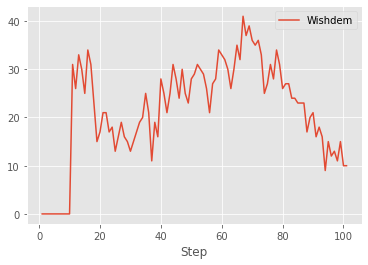

In [121]:
out.plot()

df = df.assign(a=out.Wishdem)
df

In [114]:
df = pd.DataFrame()
a=[]
for i in range(100):
    out = model.datacollector.get_agent_vars_dataframe().groupby('Step').sum()
    #df= df.assign(a=out.Wishdem)
    a=list(out.Wishdem)
a

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 11,
 11,
 11,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16]

In [612]:
#  запускаем 100 интераций модели для кросс-валидации
a=[]
df = pd.DataFrame()
iterator = 1
for j in range(100):
    col_name = 'ABC' + str(iterator)
    model = MyModel(100, 15, 15, 0.03, 0.04)
    model.run()
    out = model.datacollector.get_agent_vars_dataframe().groupby('Step').sum()
    a=list(out.Wishdem)
    df.loc[:, col_name] = a
    iterator += 1 
df

,ABC1,ABC2,ABC3,ABC4,ABC5,ABC6,ABC7,ABC8,ABC9,ABC10,...,ABC91,ABC92,ABC93,ABC94,ABC95,ABC96,ABC97,ABC98,ABC99,ABC100
0,42,41,40,33,49,36,31,38,33,41,...,40,29,37,35,43,32,34,32,36,33
1,28,23,25,28,42,22,21,34,25,19,...,26,16,21,34,28,25,17,27,28,17
2,19,19,13,23,27,14,20,25,22,23,...,18,14,13,33,22,18,13,26,18,19
3,26,27,18,20,22,12,19,17,22,23,...,19,16,8,23,12,15,12,22,18,17
4,15,27,19,21,26,8,20,22,11,19,...,20,15,4,23,16,20,11,13,14,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,17,19,18,15,18,21,19,24,18,17,...,20,32,23,20,17,21,24,18,17,9
97,17,16,15,12,11,24,17,22,22,14,...,20,23,21,16,8,20,22,9,13,13
98,16,18,13,12,8,20,18,21,13,20,...,27,32,18,14,11,28,20,14,14,19
99,21,21,17,16,6,15,17,22,18,17,...,27,26,19,10,12,22,22,25,14,28


In [614]:
df.to_excel('Автор_40шок05_связи2_дем_1515_03_04_репр15.xlsx')

In [142]:
df['mean'] = df.mean(axis=1)
df

,ABC1,ABC2,ABC3,ABC4,ABC5,ABC6,ABC7,ABC8,ABC9,ABC10,...,ABC92,ABC93,ABC94,ABC95,ABC96,ABC97,ABC98,ABC99,ABC100,mean
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.00
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.00
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.00
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.00
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,20,0,0,4,0,11,0,0,0,0,...,8,0,8,0,0,0,2,12,0,2.47
97,17,0,0,9,0,13,0,0,0,0,...,7,0,5,0,0,0,5,16,0,2.44
98,18,0,0,6,0,10,0,0,0,0,...,7,0,2,0,0,0,8,13,0,2.08
99,17,0,0,8,0,11,0,0,0,0,...,7,0,4,0,0,0,13,10,0,2.15


In [ ]:
df['twenty']= []

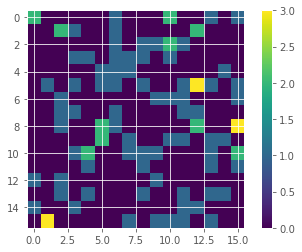

In [659]:
agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()

In [656]:
random.random()

0.5874193777788951

In [ ]:
agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()

In [ ]:
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer


# Визуализация итогов модели

## Богатая автократия со слабой политической культурой

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab


In [86]:
df=pd.read_excel('Визуализация богатая автократия.xlsx')
df

,Шаги,Богатыйавтор_нетшок_связи05_нетдем_1515_05_049_репр10,Богатыйавтор_нетшок_связи05_нетдем_1515_05_049_репр15,Богатыйавтор_нетшок_нетсвязи_нетдем_1515_05_049_репр10,Богатыйавтор_10шок09_связи05_нетдем_1515_05_049_репр10,Богатыйавтор_нетшок_связи05_дем_1515_05_049_репр10,Богатыйавтор_40шок09_связи05_нетдем_1515_05_049_репр10
0,1,0.000000,0.000000,0.000000,0.000000,12.613861,0.000000
1,2,0.009901,0.009901,0.009901,0.009901,2.534653,0.009901
2,3,0.019802,0.019802,0.019802,0.019802,0.722772,0.019802
3,4,0.029703,0.029703,0.029703,0.029703,0.237624,0.029703
4,5,0.039604,0.039604,0.039604,0.039604,0.178218,0.039604
...,...,...,...,...,...,...,...
96,97,20.514851,25.356436,18.297030,19.881188,19.762376,20.376238
97,98,20.277228,25.544554,18.455446,19.465347,19.871287,21.059406
98,99,20.841584,25.584158,18.534653,20.108911,19.920792,21.306931
99,100,20.782178,25.831683,18.653465,19.920792,20.217822,20.871287


In [4]:
def add_titlebox1(ax, text):
    ax.text(.07, .87, text,
        horizontalalignment='center',
        transform=ax.transAxes,
        bbox=dict(facecolor='white', alpha=0.6),
        fontsize=15)
    return ax

def add_titlebox2(ax, text):
    ax.text(.07, .8, text,
        horizontalalignment='center',
        transform=ax.transAxes,
        bbox=dict(facecolor='white', alpha=0.6),
        fontsize=15)
    return ax

def add_titlebox3(ax, text):
    ax.text(.07, .73, text,
        horizontalalignment='center',
        transform=ax.transAxes,
        bbox=dict(facecolor='white', alpha=0.6),
        fontsize=15)
    return ax

def add_titlebox4(ax, text):
    ax.text(.07, .66, text,
        horizontalalignment='center',
        transform=ax.transAxes,
        bbox=dict(facecolor='white', alpha=0.6),
        fontsize=15)
    return ax

In [14]:
import matplotlib.gridspec as gridspec

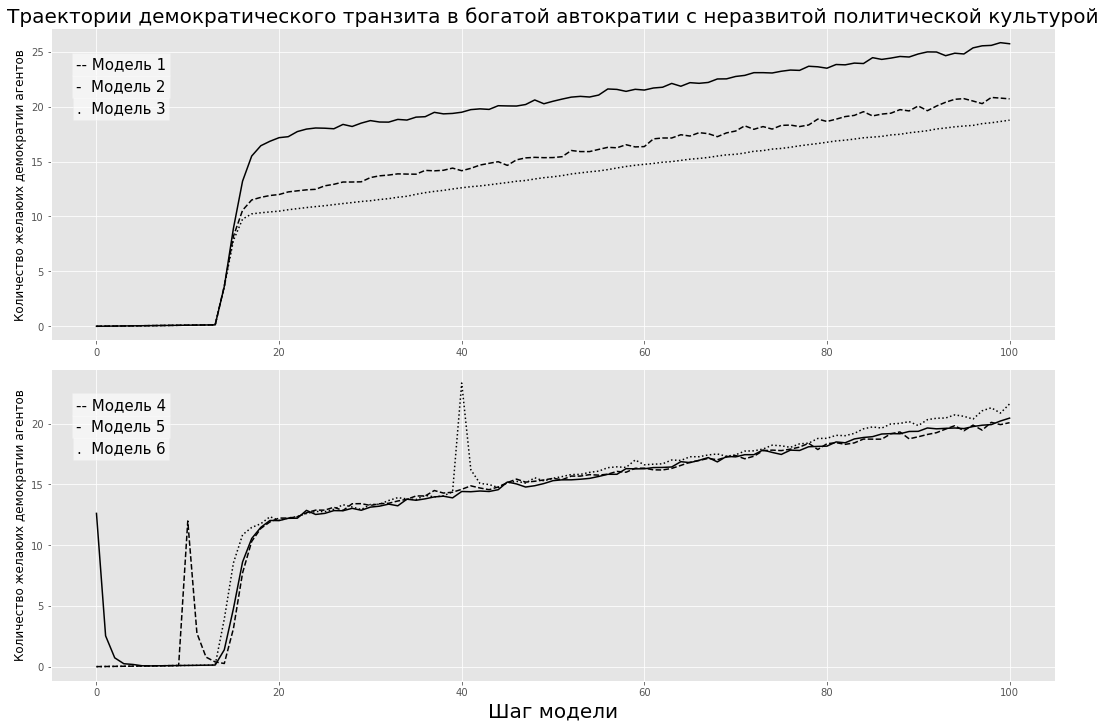

In [71]:
gridsize = (4, 2)
plt.style.use('ggplot') 

fig = plt.figure(figsize=(18, 12))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid(gridsize, (2, 0), colspan=2, rowspan=2)

ax1.set_title(
    'Траектории демократического транзита в богатой автократии с неразвитой политической культурой',
    fontsize=20
)

#gs = gridspec.GridSpec(2, 1, figure=fig)
#ax = fig.add_subplot()

ax1.plot( df['Богатыйавтор_нетшок_связи05_нетдем_1515_05_049_репр10'], color='#000000', linestyle = '--', label = 'Модель 1')
ax1.plot( df['Богатыйавтор_нетшок_связи05_нетдем_1515_05_049_репр15'], color='#000000', linestyle = '-', label = 'Модель 2')
ax1.plot( df['Богатыйавтор_нетшок_нетсвязи_нетдем_1515_05_049_репр10'], color='#000000', linestyle = ':', label = 'Модель 3')

add_titlebox1(ax1, '-- Модель 1')
add_titlebox2(ax1, '-  Модель 2')
add_titlebox3(ax1, '.  Модель 3')

ax2.set_xlabel('Шаг модели', fontsize=20, color='#000000')
ax2.set_ylabel('Количество желаюих демократии агентов', fontsize=12, color='#000000')
ax1.set_ylabel('Количество желаюих демократии агентов', fontsize=12, color='#000000')

ax2.plot( df['Богатыйавтор_10шок09_связи05_нетдем_1515_05_049_репр10'], color='#000000', linestyle = '--', label = 'Модель 4')
ax2.plot( df['Богатыйавтор_нетшок_связи05_дем_1515_05_049_репр10'], color='#000000', linestyle = '-', label = 'Модель 5')
ax2.plot( df['Богатыйавтор_40шок09_связи05_нетдем_1515_05_049_репр10'], color='#000000', linestyle = ':', label = 'Модель 6')

add_titlebox1(ax2, '-- Модель 4')
add_titlebox2(ax2, '-  Модель 5')
add_titlebox3(ax2, '.  Модель 6')


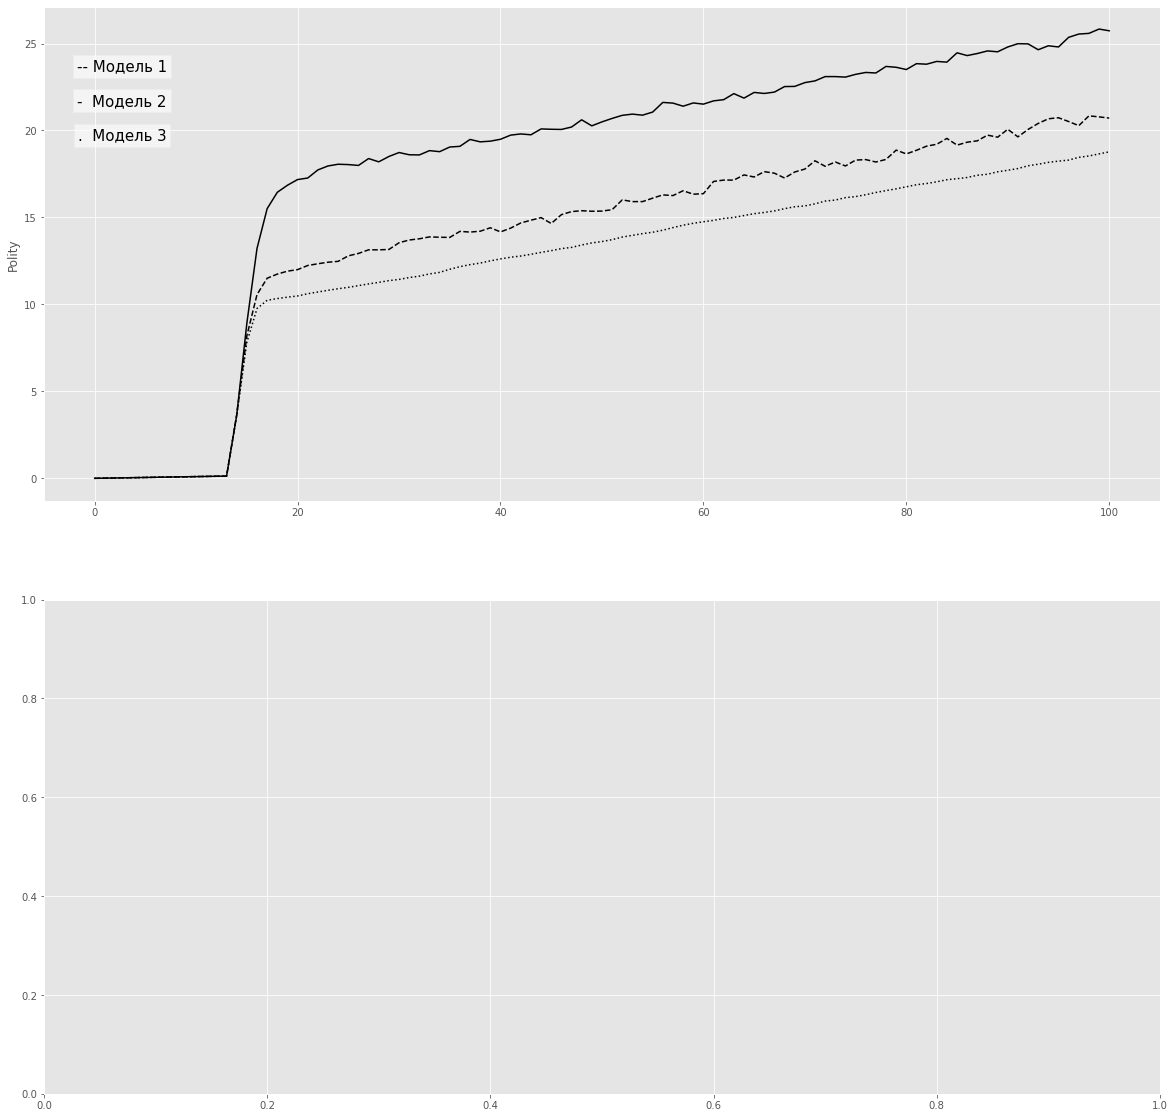

In [68]:
fig, ax = plt.subplots (2, 1, figsize=(20, 20))

#ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
#ax2 = plt.subplot2grid(gridsize, (2, 0), colspan=2, rowspan=2)

#ax1.set_title(
  #  'Траектории демократического транзита в богатой автократии с неразвитой политической культурой',
#    fontsize=20
#)

ax[0].set_ylabel('Polity')

#gs = gridspec.GridSpec(2, 1, figure=fig)
#ax = fig.add_subplot()

ax[0].plot( df['Богатыйавтор_нетшок_связи05_нетдем_1515_05_049_репр10'], color='#000000', linestyle = '--', label = 'Модель 1')
ax[0].plot( df['Богатыйавтор_нетшок_связи05_нетдем_1515_05_049_репр15'], color='#000000', linestyle = '-', label = 'Модель 2')
ax[0].plot( df['Богатыйавтор_нетшок_нетсвязи_нетдем_1515_05_049_репр10'], color='#000000', linestyle = ':', label = 'Модель 3')

add_titlebox1(ax[0], '-- Модель 1')
add_titlebox2(ax[0], '-  Модель 2')
add_titlebox3(ax[0], '.  Модель 3')

#ax2.set_xlabel('Шаг модели', fontsize=20, color='#000000')
#ax1.set_ylabel('Количество желаюих демократии агентов', fontsize=20, color='#000000')


ax2.plot( df['Богатыйавтор_10шок09_связи05_нетдем_1515_05_049_репр10'], color='#000000', linestyle = '--', label = 'Модель 4')
ax2.plot( df['Богатыйавтор_нетшок_связи05_дем_1515_05_049_репр10'], color='#000000', linestyle = '-', label = 'Модель 5')
ax2.plot( df['Богатыйавтор_40шок09_связи05_нетдем_1515_05_049_репр10'], color='#000000', linestyle = ':', label = 'Модель 6')

add_titlebox1(ax2, '-- Модель 4')
add_titlebox2(ax2, '-  Модель 5')
add_titlebox3(ax2, '.  Модель 6')

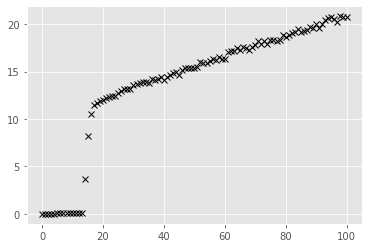

In [375]:
import pylab

from matplotlib import mlab

pylab.plot (df['Богатыйавтор_нетшок_связи05_нетдем_1515_05_049_репр10'], "x", color='#000000', label = 'Модель 1')

pylab.show()


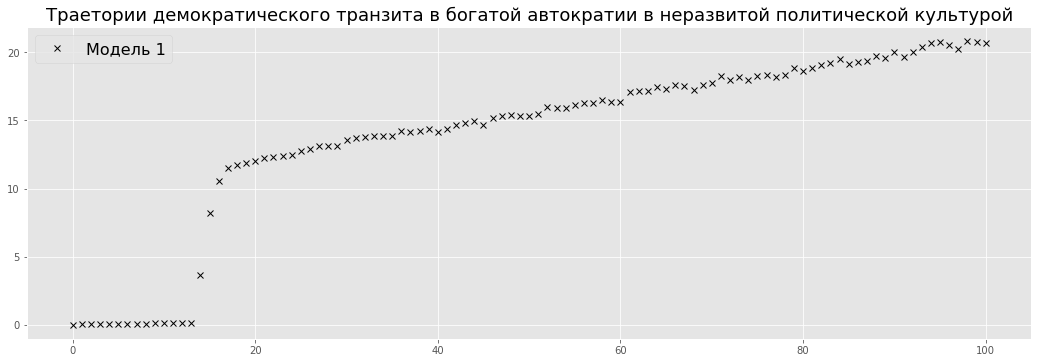

In [276]:
gridsize = (4, 2)
plt.style.use('ggplot') 

fig = plt.figure(figsize=(18, 12))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)

ax1.set_title(
    'Траетории демократического транзита в богатой автократии в неразвитой политической культурой',
    fontsize=18
)

pylab.plot (df['Богатыйавтор_нетшок_связи05_нетдем_1515_05_049_репр10'], "x", color='#000000', label = 'Модель 1')


plt.legend(fontsize=16) 

https://habr.com/ru/post/468295/

https://pythonguides.com/matplotlib-fill_between/

https://stackoverflow.com/questions/18386106/matplotlib-hatched-fill-between-without-edges

https://coderoad.ru/25901294/%D0%A8%D1%82%D1%80%D0%B8%D1%85%D0%BE%D0%B2%D0%BA%D0%B0-%D0%BE%D0%B1%D0%BB%D0%B0%D1%81%D1%82%D0%B8-%D0%BC%D0%B5%D0%B6%D0%B4%D1%83-%D0%B4%D0%B2%D1%83%D0%BC%D1%8F-%D0%BE%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%BD%D1%8B%D0%BC%D0%B8-%D1%84%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F%D0%BC%D0%B8-%D0%B2-matplotlib

https://fooobar.com/questions/17072590/python-how-to-make-shaded-areas-or-alternating-background-color-using-plotly -заштрихованные области

https://stackoverflow.com/questions/66902694/ax-fill-between-how-to-blend-overlapping-colors

https://pyprog.pro/mpl/mpl_fill_between.html

https://matplotlib.org/stable/gallery/lines_bars_and_markers/psd_demo.html#sphx-glr-gallery-lines-bars-and-markers-psd-demo-py

https://matplotlib.org/stable/tutorials/intermediate/artists.html#sphx-glr-tutorials-intermediate-artists-py

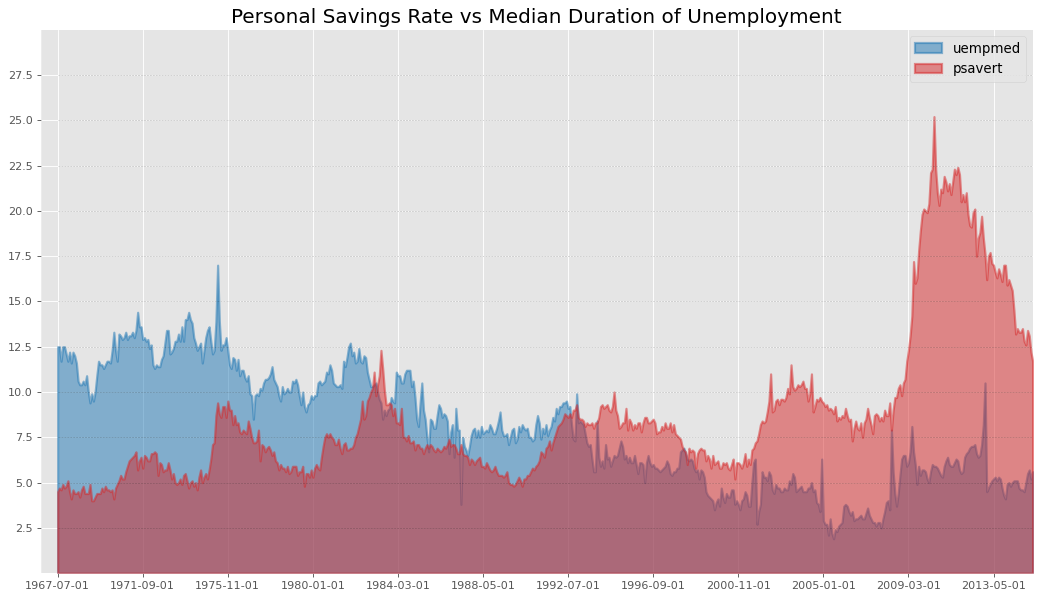

In [343]:
df = pd.read_csv("https://github.com/selva86/datasets/raw/master/economics.csv")

# Prepare Data
x = df['date'].values.tolist()
y1 = df['psavert'].values.tolist()
y2 = df['uempmed'].values.tolist()
mycolors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:brown', 'tab:grey', 'tab:pink', 'tab:olive']      
columns = ['psavert', 'uempmed']

# Draw Plot 
fig, ax = plt.subplots(1, 1, figsize=(16,9), dpi= 80)
ax.fill_between(x, y1=y1, y2=0, label=columns[1], alpha=0.5, color=mycolors[1], linewidth=2)
ax.fill_between(x, y1=y2, y2=0, label=columns[0], alpha=0.5, color=mycolors[0], linewidth=2)

# Decorations
ax.set_title('Personal Savings Rate vs Median Duration of Unemployment', fontsize=18)
ax.set(ylim=[0, 30])
ax.legend(loc='best', fontsize=12)
plt.xticks(x[::50], fontsize=10, horizontalalignment='center')
plt.yticks(np.arange(2.5, 30.0, 2.5), fontsize=10)
plt.xlim(-10, x[-1])

# Draw Tick lines  
for y in np.arange(2.5, 30.0, 2.5):    
    plt.hlines(y, xmin=0, xmax=len(x), colors='black', alpha=0.3, linestyles="--", lw=0.5)

# Lighten borders
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(.3)
 
plt.show()

In [344]:
df

,date,pce,pop,psavert,uempmed,unemploy
0,1967-07-01,507.4,198712,12.5,4.5,2944
1,1967-08-01,510.5,198911,12.5,4.7,2945
2,1967-09-01,516.3,199113,11.7,4.6,2958
3,1967-10-01,512.9,199311,12.5,4.9,3143
4,1967-11-01,518.1,199498,12.5,4.7,3066
...,...,...,...,...,...,...
569,2014-12-01,12122.0,320201,5.0,12.6,8688
570,2015-01-01,12080.8,320367,5.5,13.4,8979
571,2015-02-01,12095.9,320534,5.7,13.1,8705
572,2015-03-01,12161.5,320707,5.2,12.2,8575


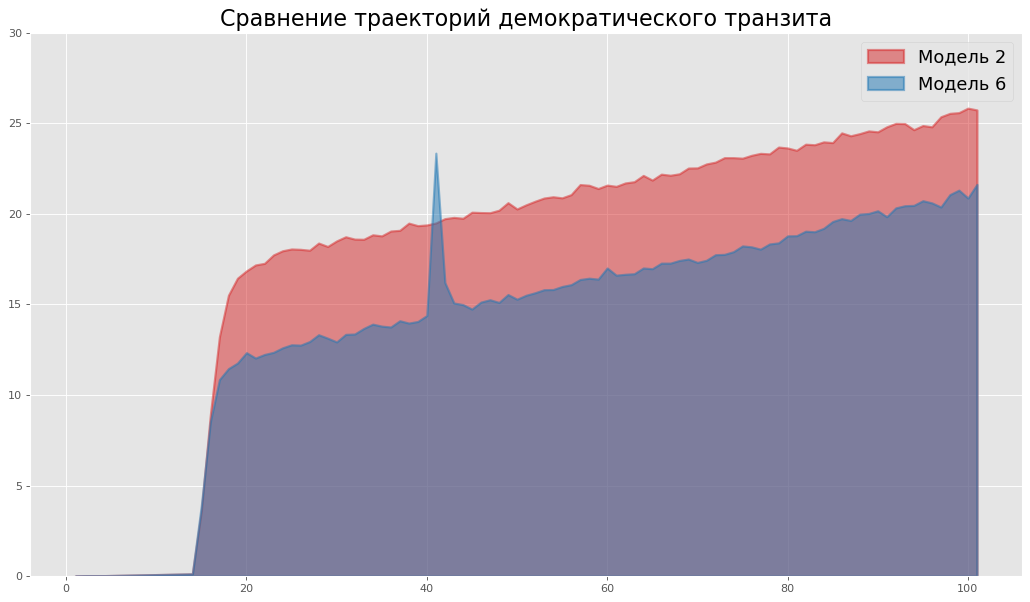

In [382]:
fig, ax = plt.subplots(1, 1, figsize=(16,9), dpi= 80)

y1=df['Богатыйавтор_нетшок_связи05_нетдем_1515_05_049_репр15']
x = df['Шаги']
y2 = df['Богатыйавтор_40шок09_связи05_нетдем_1515_05_049_репр10']
ax.fill_between(x, y1=y1, y2=0, alpha=0.5, color='tab:red', linewidth=2, label='Модель 2')

ax.fill_between(x, y1=y2, y2=0, alpha=0.5, color='tab:blue', linewidth=2, label='Модель 6')

# Decorations
ax.set_title('Сравнение траекторий демократического транзита', fontsize=20)
ax.set(ylim=[0, 30])



plt.legend(fontsize=16) 
plt.show()

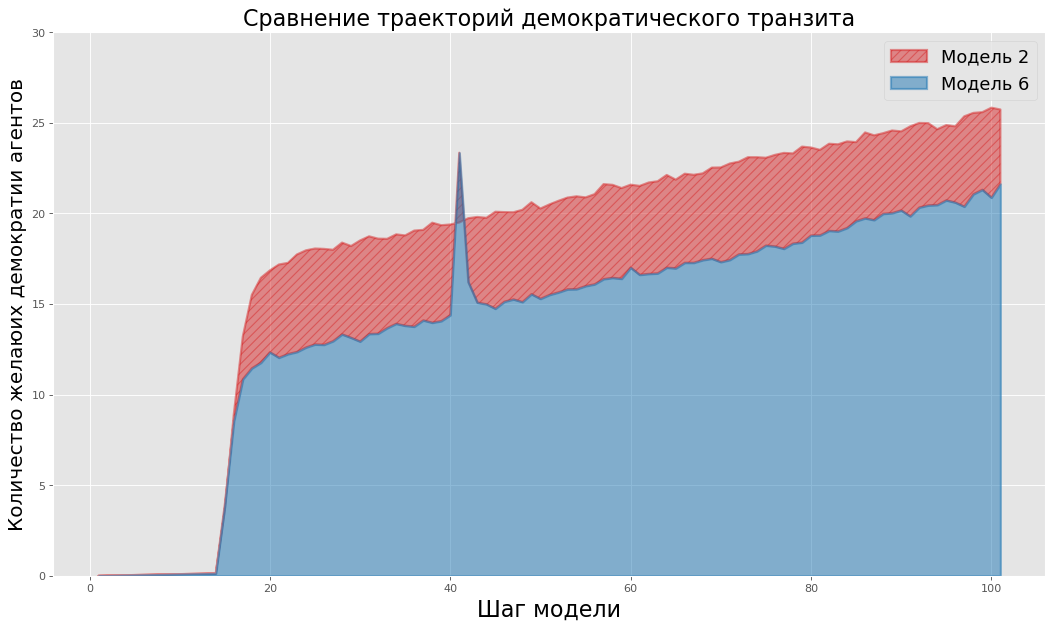

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(16,9), dpi= 80)

y1=df['Богатыйавтор_нетшок_связи05_нетдем_1515_05_049_репр15']
x = df['Шаги']
y2 = df['Богатыйавтор_40шок09_связи05_нетдем_1515_05_049_репр10']
ax.fill_between(x, y1=y1, y2=y2, alpha=0.5, color='tab:red', linewidth=2, hatch = '///', label='Модель 2')

ax.fill_between(x, y1=y2, y2=0, alpha=0.5, color='tab:blue', linewidth=2, label='Модель 6')

# Decorations
ax.set_title('Сравнение траекторий демократического транзита', fontsize=20)
ax.set(ylim=[0, 30])

ax.set_xlabel('Шаг модели', fontsize=20, color='#000000')
ax.set_ylabel('Количество желаюих демократии агентов', fontsize=18, color='#000000')


plt.legend(fontsize=16) 
plt.show()

## Культурная автократия

In [102]:
df=pd.read_excel('Визуализация культурная автократия.xlsx')
df

,Шаги,Автор_нетшок_связи2_нетдем_1515_03_04_репр10,Автор_нетшок_связи2_нетдем_1515_03_04_репр15,Автор_10шок05_связи2_нетдем_1515_03_04_репр15,Автор_10шок05_связи2_дем_1515_03_04_репр15,Автор_нетшок_связи3_нетдем_1515_03_04_репр15,Автор_10шок05_связи3_нетдем_1515_03_04_репр15,Автор_40шок05_связи2_дем_1515_03_04_репр15
0,1,0.000000,0.000000,0.000000,37.366337,0.000000,0.000000,37.435644
1,2,0.009901,0.009901,0.009901,25.475248,0.009901,0.009901,25.900990
2,3,0.019802,0.019802,0.019802,20.702970,0.019802,0.019802,20.633663
3,4,0.029703,0.029703,0.029703,17.970297,0.029703,0.029703,17.881188
4,5,0.039604,0.039604,0.039604,16.138614,0.039604,0.039604,16.653465
...,...,...,...,...,...,...,...,...
96,97,12.980198,18.435644,17.495050,18.702970,33.821782,33.603960,18.742574
97,98,13.346535,17.623762,17.881188,18.831683,33.346535,34.039604,17.663366
98,99,13.326733,17.732673,18.504950,18.792079,32.960396,33.950495,18.475248
99,100,13.257426,18.099010,18.673267,18.940594,32.970297,33.534653,18.792079


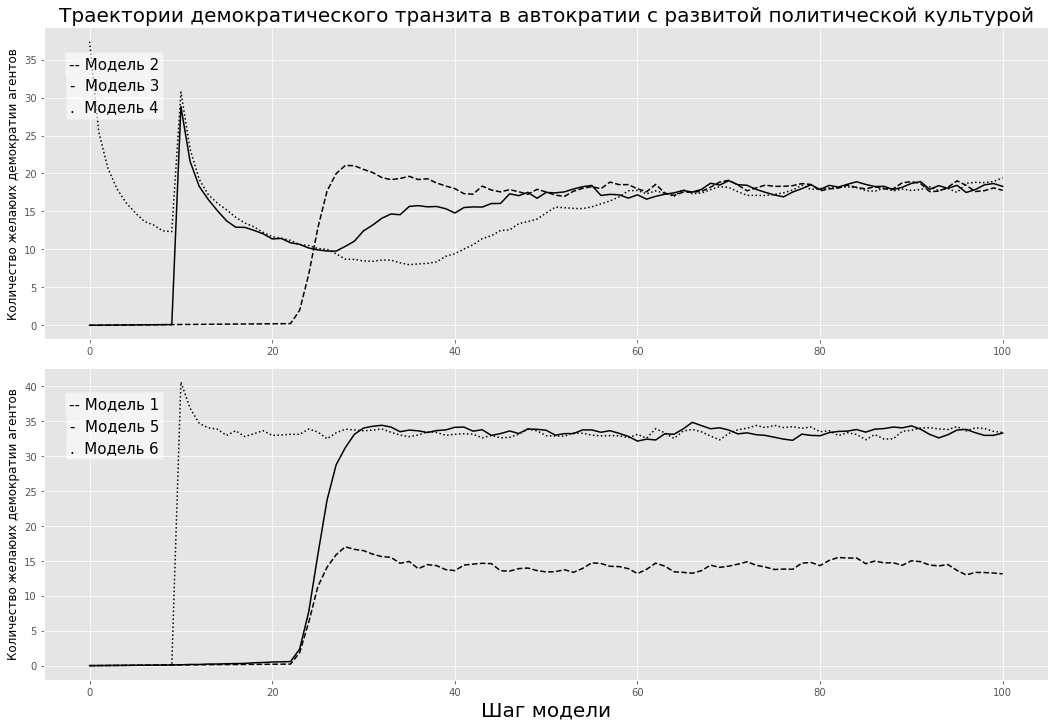

In [79]:
gridsize = (4, 2)
plt.style.use('ggplot') 

fig = plt.figure(figsize=(18, 12))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid(gridsize, (2, 0), colspan=2, rowspan=2)

ax1.set_title(
    'Траектории демократического транзита в автократии с развитой политической культурой',
    fontsize=20
)

ax1.plot( df['Автор_нетшок_связи2_нетдем_1515_03_04_репр15'], color='#000000', linestyle = '--', label = 'Модель 2')
ax1.plot( df['Автор_10шок05_связи2_нетдем_1515_03_04_репр15'], color='#000000', linestyle = '-', label = 'Модель 3')
ax1.plot( df['Автор_10шок05_связи2_дем_1515_03_04_репр15'], color='#000000', linestyle = ':', label = 'Модель 4')

add_titlebox1(ax1, '-- Модель 2')
add_titlebox2(ax1, '-  Модель 3')
add_titlebox3(ax1, '.  Модель 4')

ax2.plot( df['Автор_нетшок_связи2_нетдем_1515_03_04_репр10'], color='#000000', linestyle = '--', label = 'Модель 1')
ax2.plot( df['Автор_нетшок_связи3_нетдем_1515_03_04_репр15'], color='#000000', linestyle = '-', label = 'Модель 5')
ax2.plot( df['Автор_10шок05_связи3_нетдем_1515_03_04_репр15'], color='#000000', linestyle = ':', label = 'Модель 6')

ax2.set_xlabel('Шаг модели', fontsize=20, color='#000000')
ax2.set_ylabel('Количество желаюих демократии агентов', fontsize=12, color='#000000')
ax1.set_ylabel('Количество желаюих демократии агентов', fontsize=12, color='#000000')


add_titlebox1(ax2, '-- Модель 1')
add_titlebox2(ax2, '-  Модель 5')
add_titlebox3(ax2, '.  Модель 6')


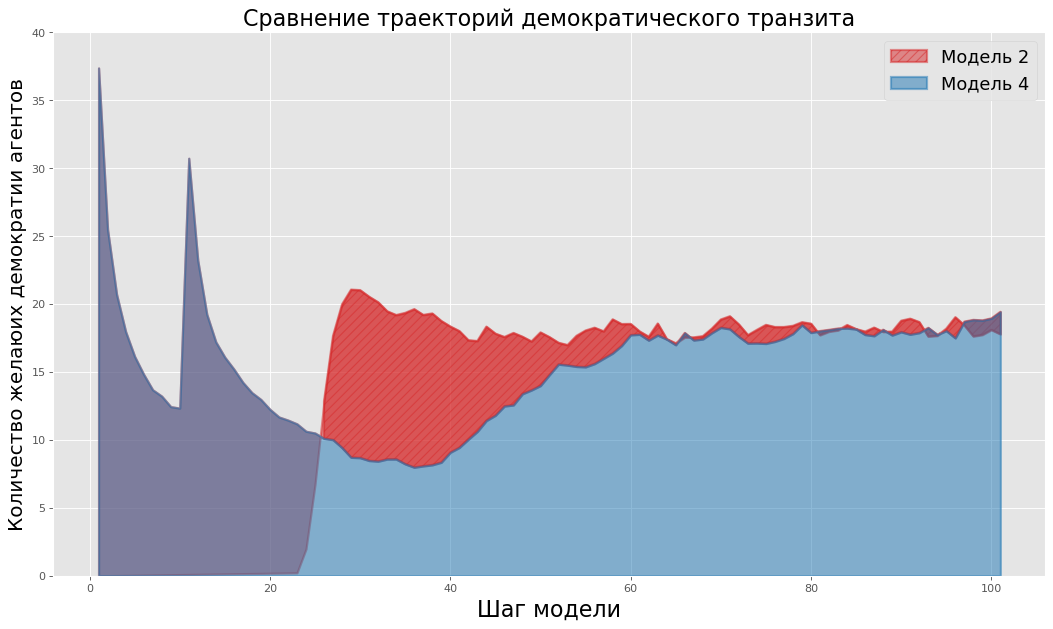

In [117]:
fig, ax = plt.subplots(1, 1, figsize=(16,9), dpi= 80)

y1=df['Автор_нетшок_связи2_нетдем_1515_03_04_репр15']
x = df['Шаги']
y2 = df['Автор_10шок05_связи2_дем_1515_03_04_репр15']
ax.fill_between(x, y1=y1, y2=y2, alpha=0.5, color='tab:red', linewidth=2)

ax.fill_between(x, y1=y1, y2=y2, alpha=0.5, color='tab:red', linewidth=2, hatch= '///', where=(x>25),label='Модель 2')

ax.fill_between(x, y1=y2, y2=0, alpha=0.5, color='tab:blue', linewidth=2, label='Модель 4')

# Decorations
ax.set_title('Сравнение траекторий демократического транзита', fontsize=20)
ax.set(ylim=[0, 40])

ax.set_xlabel('Шаг модели', fontsize=20, color='#000000')
ax.set_ylabel('Количество желаюих демократии агентов', fontsize=18, color='#000000')

plt.legend(fontsize=16) 
plt.show()

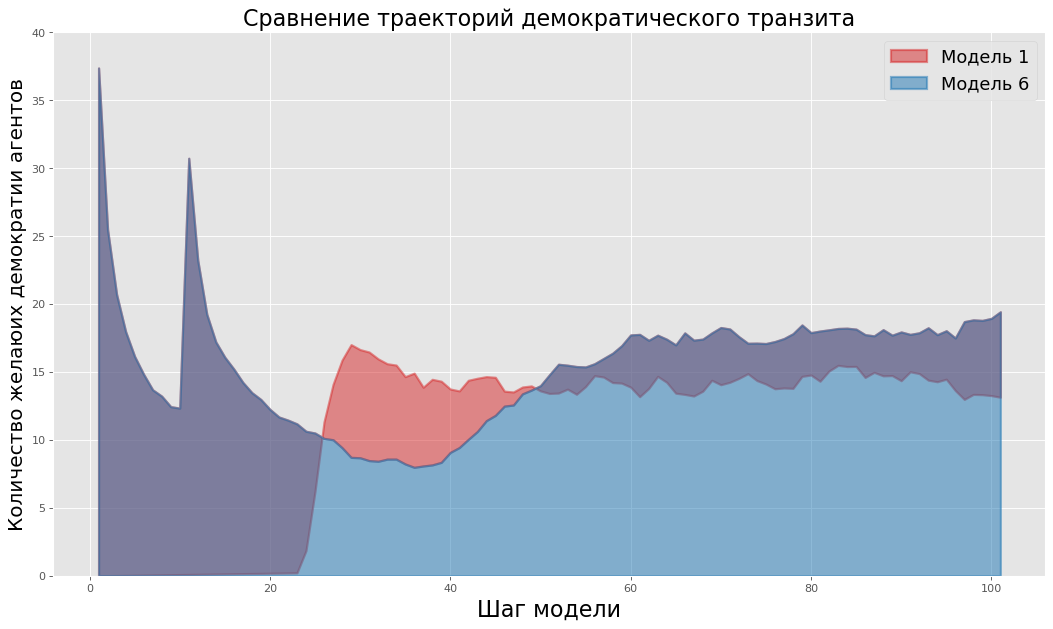

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(16,9), dpi= 80)

y1=df['Автор_нетшок_связи2_нетдем_1515_03_04_репр10']
x = df['Шаги']
y2 = df['Автор_10шок05_связи2_дем_1515_03_04_репр15']
ax.fill_between(x, y1=y1, y2=y2, alpha=0.5, color='tab:red', linewidth=2, label='Модель 1')

ax.fill_between(x, y1=y2, y2=0, alpha=0.5, color='tab:blue', linewidth=2, label='Модель 6')

# Decorations
ax.set_title('Сравнение траекторий демократического транзита', fontsize=20)
ax.set(ylim=[0, 40])

ax.set_xlabel('Шаг модели', fontsize=20, color='#000000')
ax.set_ylabel('Количество желаюих демократии агентов', fontsize=18, color='#000000')

plt.legend(fontsize=16) 
plt.show()

## Визуализация Индия

In [82]:
df=pd.read_excel('Визуалиpация Индия.xlsx')
df

,Индия_нетшок_связи03_нетдем_нетурбан(100 1616).xlsx,Индия_шок10_связи03_нетдем_нетурбан(100 1616).xlsx,Индия_нетшок_связи03_дем_нетурбан(100 1616).xlsx,Индия_шок_связи03_дем_нетурбан(100 1616).xlsx
0,0.000000,0.000000,43.435644,42.930693
1,0.009901,0.009901,33.376238,33.366337
2,0.019802,0.019802,29.524752,30.940594
3,0.029703,0.029703,28.019802,27.871287
4,0.039604,0.039604,26.732673,26.396040
...,...,...,...,...
96,23.039604,22.267327,22.742574,22.940594
97,23.544554,21.990099,22.207921,22.356436
98,23.970297,22.089109,22.574257,22.079208
99,23.217822,21.534653,22.594059,21.881188


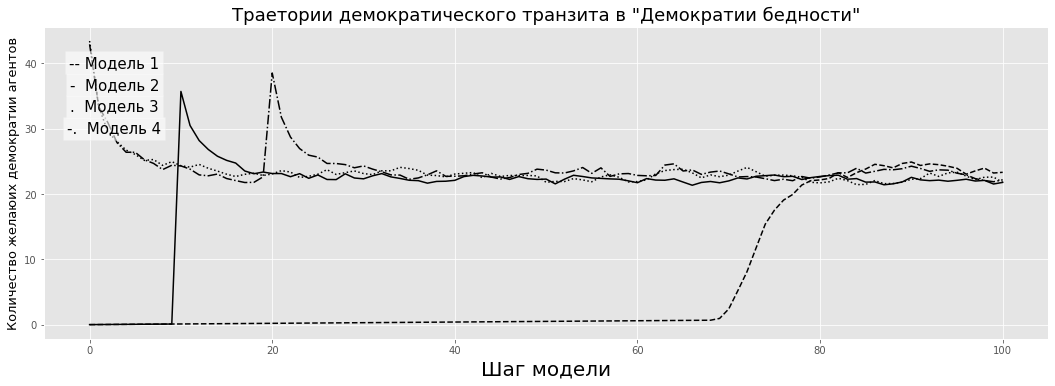

In [85]:
gridsize = (4, 2)
plt.style.use('ggplot') 

fig = plt.figure(figsize=(18, 12))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)

ax1.set_title(
    'Траетории демократического транзита в "Демократии бедности"',
    fontsize=18
)


ax1.plot( df['Индия_нетшок_связи03_нетдем_нетурбан(100 1616).xlsx'], color='#000000', linestyle = '--', label = 'Модель 2')
ax1.plot( df['Индия_шок10_связи03_нетдем_нетурбан(100 1616).xlsx'], color='#000000', linestyle = '-', label = 'Модель 3')
ax1.plot( df['Индия_нетшок_связи03_дем_нетурбан(100 1616).xlsx'], color='#000000', linestyle = ':', label = 'Модель 4')
ax1.plot( df['Индия_шок_связи03_дем_нетурбан(100 1616).xlsx'], color='#000000', linestyle = '-.', label = 'Модель 4')

ax1.set_xlabel('Шаг модели', fontsize=20, color='#000000')
ax1.set_ylabel('Количество желаюих демократии агентов', fontsize=13, color='#000000')

add_titlebox1(ax1, '-- Модель 1')
add_titlebox2(ax1, '-  Модель 2')
add_titlebox3(ax1, '.  Модель 3')
add_titlebox4(ax1, '-.  Модель 4')

# Event-count регрессия

In [8]:
import numpy as np
import pandas as pd
import os 
import statsmodels as sm
from plotnine import *

In [35]:
data_estimation = pd.read_excel('Регрессия.xlsx')

#summarize data
data_estimation.describe(include = 'all')

,Название,Intercept,more20,income,repression,connect,strong_connect,shock,dem
count,1500,1500.0,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
unique,510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Индия_шок_связи03_дем_нетурбан(100 1616),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.0,28.839333,0.032667,0.040933,0.600000,0.170000,0.600000,0.400000
std,NaN,0.0,28.193204,0.016116,0.007631,0.490061,0.112287,0.490061,0.490061
min,NaN,1.0,0.000000,0.010000,0.030000,0.000000,0.000000,0.000000,0.000000
25%,NaN,1.0,7.000000,0.010000,0.030000,0.000000,0.050000,0.000000,0.000000
50%,NaN,1.0,19.000000,0.030000,0.040000,1.000000,0.200000,1.000000,0.000000
75%,NaN,1.0,47.000000,0.050000,0.049000,1.000000,0.300000,1.000000,1.000000


In [14]:
data_estimation

,Название,Intercept,more20,income,repression,connect,strong_connect,shock,dem
0,Богатыйавтор_10шок05_связи05_нетдем_1515_05_04...,1,2,0.05,0.049,0,0.05,1,0
1,Богатыйавтор_10шок05_связи05_нетдем_1515_05_04...,1,22,0.05,0.049,0,0.05,1,0
2,Богатыйавтор_10шок05_связи05_нетдем_1515_05_04...,1,19,0.05,0.049,0,0.05,1,0
3,Богатыйавтор_10шок05_связи05_нетдем_1515_05_04...,1,3,0.05,0.049,0,0.05,1,0
4,Богатыйавтор_10шок05_связи05_нетдем_1515_05_04...,1,12,0.05,0.049,0,0.05,1,0
...,...,...,...,...,...,...,...,...,...
1495,Индия_шок_связи03_дем_нетурбан(100 1616),1,65,0.01,0.030,1,0.30,1,1
1496,Индия_шок_связи03_дем_нетурбан(100 1616),1,79,0.01,0.030,1,0.30,1,1
1497,Индия_шок_связи03_дем_нетурбан(100 1616),1,45,0.01,0.030,1,0.30,1,1
1498,Индия_шок_связи03_дем_нетурбан(100 1616),1,24,0.01,0.030,1,0.30,1,1


In [33]:
model = sm.discrete.discrete_model.Poisson.from_formula('more20 ~ shock*connect + dem*connect + repression + connect + shock + dem', 
                                                      data = data_estimation)
results = model.fit()
print(results.summary())
#save the log-like likelihood for the likelihood ratio test
log_likelihood_full = results.llf

Optimization terminated successfully.
         Current function value: 8.532222
         Iterations 7
                          Poisson Regression Results                          
Dep. Variable:                 more20   No. Observations:                 1500
Model:                        Poisson   Df Residuals:                     1493
Method:                           MLE   Df Model:                            6
Date:                Thu, 04 Nov 2021   Pseudo R-squ.:                  0.4611
Time:                        14:58:08   Log-Likelihood:                -12798.
converged:                       True   LL-Null:                       -23751.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         4.4615      0.058     76.572      0.000       4.347       4.576
shock             0.

In [28]:
import statsmodels.api as smo #ОБЫЧНАЯ РЕГРЕССИЯ
model1 = smo.OLS.from_formula('more20 ~ income+ repression + connect + strong_connect+shock + dem', 
                                                      data = data_estimation)
results1 = model1.fit()
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:                 more20   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     734.6
Date:                Thu, 04 Nov 2021   Prob (F-statistic):               0.00
Time:                        14:50:25   Log-Likelihood:                -6205.9
No. Observations:                1500   AIC:                         1.242e+04
Df Residuals:                    1494   BIC:                         1.246e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -96.2088      5.581    -17.

In [74]:
model = sm.discrete.discrete_model.Poisson.from_formula('more20 ~ income+ repression + connect + strong_connect+shock + dem', 
                                                      data = data_estimation)
results = model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 5.677544
         Iterations 20
                          Poisson Regression Results                          
Dep. Variable:                 more20   No. Observations:                 1500
Model:                        Poisson   Df Residuals:                     1494
Method:                           MLE   Df Model:                            5
Date:                Thu, 04 Nov 2021   Pseudo R-squ.:                  0.6414
Time:                        18:44:23   Log-Likelihood:                -8516.3
converged:                       True   LL-Null:                       -23751.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.6696        nan        nan        nan         nan         nan
income          

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1354: RuntimeWarning: invalid value encountered in sqrt


In [69]:
model = sm.discrete.discrete_model.Poisson.from_formula('more20 ~ repression + connect + shock + dem', 
                                                      data = data_estimation)
results = model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 8.561887
         Iterations 6
                          Poisson Regression Results                          
Dep. Variable:                 more20   No. Observations:                 1500
Model:                        Poisson   Df Residuals:                     1495
Method:                           MLE   Df Model:                            4
Date:                Thu, 04 Nov 2021   Pseudo R-squ.:                  0.4593
Time:                        18:28:40   Log-Likelihood:                -12843.
converged:                       True   LL-Null:                       -23751.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.4336      0.053     83.462      0.000       4.329       4.538
repression   -53.9424      1.

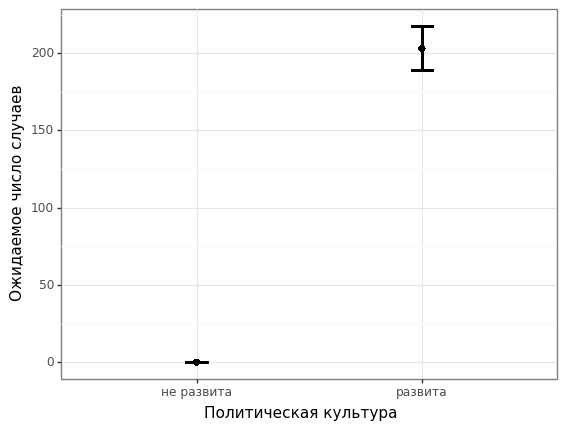

<ggplot: (136786211825)>

In [67]:
variance_covariance = results.cov_params()
#draw the sample 
coef_distribution = np.random.multivariate_normal(results.params,variance_covariance,size=10000)
binary_variables = ['shock', 'dem']
continuous_variables = ['repression']
#set binary variables to modes and continuous variables to means
data_plot = data_estimation[['Intercept', 'connect', 'shock', 'dem', 'repression']].copy()
for x in binary_variables:
    mean_value = np.mean(data_plot[x])
    if mean_value >=0.5:
        data_plot[x] = 1
    else:
        data_plot[x] = 0
for x in continuous_variables:
    data_plot[x] = np.mean(data_plot[x])
#multiple matrix of independent variables by the possible values of regression coefficients
matrix_score = np.exp(np.dot(data_plot, np.transpose(coef_distribution)))
predicted_arrests = np.mean(matrix_score, axis = 1)
upper_bound = np.percentile(matrix_score, axis = 1, q = 97.5)
lower_bound = np.percentile(matrix_score, axis = 1, q = 2.5)
data_plot.loc[(data_plot['connect']) == 0,'Identity'] = 'развита'
data_plot.loc[(data_plot['connect']) == 1,'Identity'] = 'не развита'
data_illustration = pd.DataFrame({'Политическая культура': data_plot['Identity'],
                                  'Predicted Counts': predicted_arrests,
                                  'Upper Bound': upper_bound,
                                  'Lower Bound': lower_bound})
plot = (ggplot(data_illustration, aes(x = 'Политическая культура'))+
        geom_point(aes(y = 'Predicted Counts'), colour = 'black')+
        geom_errorbar(aes(ymin = 'Upper Bound', ymax = 'Lower Bound'), width = 0.1)+
        theme_bw()+
        ylab('Ожидаемое число случаев'))
plot

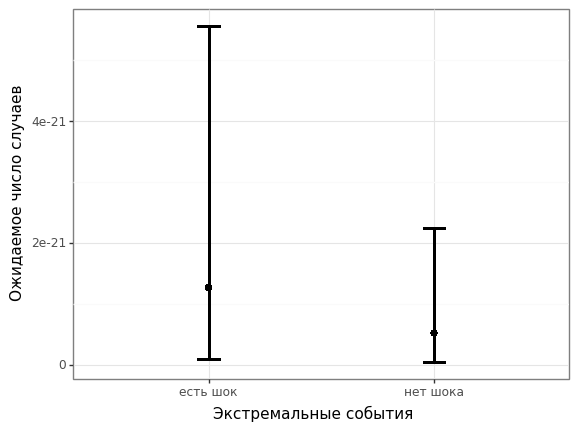

<ggplot: (136787194959)>

In [71]:
variance_covariance = results.cov_params()
#draw the sample 
coef_distribution = np.random.multivariate_normal(results.params,variance_covariance,size=10000)
binary_variables = ['connect', 'dem']
continuous_variables = ['repression']
#set binary variables to modes and continuous variables to means
data_plot = data_estimation[['Intercept', 'connect', 'shock', 'dem', 'repression']].copy()
for x in binary_variables:
    mean_value = np.mean(data_plot[x])
    if mean_value >=0.5:
        data_plot[x] = 1
    else:
        data_plot[x] = 0
for x in continuous_variables:
    data_plot[x] = np.mean(data_plot[x])
#multiple matrix of independent variables by the possible values of regression coefficients
matrix_score = np.exp(np.dot(data_plot, np.transpose(coef_distribution)))
predicted_arrests = np.mean(matrix_score, axis = 1)
upper_bound = np.percentile(matrix_score, axis = 1, q = 97.5)
lower_bound = np.percentile(matrix_score, axis = 1, q = 2.5)
data_plot.loc[(data_plot['shock']) == 0,'Identity'] = 'нет шока'
data_plot.loc[(data_plot['shock']) == 1,'Identity'] = 'есть шок'
data_illustration = pd.DataFrame({'Экстремальные события': data_plot['Identity'],
                                  'Predicted Counts': predicted_arrests,
                                  'Upper Bound': upper_bound,
                                  'Lower Bound': lower_bound})
plot = (ggplot(data_illustration, aes(x = 'Экстремальные события'))+
        geom_point(aes(y = 'Predicted Counts'), colour = 'black')+
        geom_errorbar(aes(ymin = 'Upper Bound', ymax = 'Lower Bound'), width = 0.1)+
        theme_bw()+
        ylab('Ожидаемое число случаев'))
plot

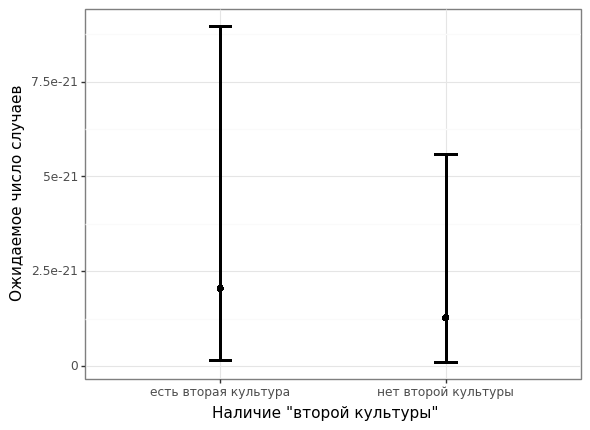

<ggplot: (136786553763)>

In [73]:
variance_covariance = results.cov_params()
#draw the sample 
coef_distribution = np.random.multivariate_normal(results.params,variance_covariance,size=10000)
binary_variables = ['connect', 'shock']
continuous_variables = ['repression']
#set binary variables to modes and continuous variables to means
data_plot = data_estimation[['Intercept', 'connect', 'shock', 'dem', 'repression']].copy()
for x in binary_variables:
    mean_value = np.mean(data_plot[x])
    if mean_value >=0.5:
        data_plot[x] = 1
    else:
        data_plot[x] = 0
for x in continuous_variables:
    data_plot[x] = np.mean(data_plot[x])
#multiple matrix of independent variables by the possible values of regression coefficients
matrix_score = np.exp(np.dot(data_plot, np.transpose(coef_distribution)))
predicted_arrests = np.mean(matrix_score, axis = 1)
upper_bound = np.percentile(matrix_score, axis = 1, q = 97.5)
lower_bound = np.percentile(matrix_score, axis = 1, q = 2.5)
data_plot.loc[(data_plot['dem']) == 0,'Identity'] = 'нет второй культуры'
data_plot.loc[(data_plot['dem']) == 1,'Identity'] = 'есть вторая культура'
data_illustration = pd.DataFrame({'Наличие "второй культуры"': data_plot['Identity'],
                                  'Predicted Counts': predicted_arrests,
                                  'Upper Bound': upper_bound,
                                  'Lower Bound': lower_bound})
plot = (ggplot(data_illustration, aes(x = 'Наличие "второй культуры"'))+
        geom_point(aes(y = 'Predicted Counts'), colour = 'black')+
        geom_errorbar(aes(ymin = 'Upper Bound', ymax = 'Lower Bound'), width = 0.1)+
        theme_bw()+
        ylab('Ожидаемое число случаев'))
plot

## Регрессионый анализ

In [56]:
model = sm.discrete.discrete_model.Poisson.from_formula('more20 ~ shock*connect + dem*connect + repression + connect + shock + dem', 
                                                      data = data_estimation)
results = model.fit()
print(results.summary())
#save the log-like likelihood for the likelihood ratio test
log_likelihood_full = results.llf

Optimization terminated successfully.
         Current function value: 8.532222
         Iterations 7
                          Poisson Regression Results                          
Dep. Variable:                 more20   No. Observations:                 1500
Model:                        Poisson   Df Residuals:                     1493
Method:                           MLE   Df Model:                            6
Date:                Thu, 04 Nov 2021   Pseudo R-squ.:                  0.4611
Time:                        15:57:49   Log-Likelihood:                -12798.
converged:                       True   LL-Null:                       -23751.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         4.4615      0.058     76.572      0.000       4.347       4.576
shock             0.

In [57]:
model = sm.discrete.discrete_model.Poisson.from_formula('more20 ~ repression + connect + shock + dem', 
                                                      data = data_estimation)
results = model.fit()
print(results.summary())
#save the log-like likelihood for the likelihood ratio test
log_likelihood_full = results.llf

Optimization terminated successfully.
         Current function value: 8.561887
         Iterations 6
                          Poisson Regression Results                          
Dep. Variable:                 more20   No. Observations:                 1500
Model:                        Poisson   Df Residuals:                     1495
Method:                           MLE   Df Model:                            4
Date:                Thu, 04 Nov 2021   Pseudo R-squ.:                  0.4593
Time:                        15:58:07   Log-Likelihood:                -12843.
converged:                       True   LL-Null:                       -23751.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.4336      0.053     83.462      0.000       4.329       4.538
repression   -53.9424      1.

In [63]:
model = sm.discrete.discrete_model.Poisson.from_formula('more20 ~ repression*dem + repression*shock + repression + connect + shock + dem', 
                                                      data = data_estimation)
results = model.fit()
print(results.summary())
#save the log-like likelihood for the likelihood ratio test
log_likelihood_full = results.llf

Optimization terminated successfully.
         Current function value: 7.947121
         Iterations 7
                          Poisson Regression Results                          
Dep. Variable:                 more20   No. Observations:                 1500
Model:                        Poisson   Df Residuals:                     1493
Method:                           MLE   Df Model:                            6
Date:                Thu, 04 Nov 2021   Pseudo R-squ.:                  0.4981
Time:                        16:35:52   Log-Likelihood:                -11921.
converged:                       True   LL-Null:                       -23751.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            3.1390      0.078     40.259      0.000       2.986       3.292
repression 